<a href="https://colab.research.google.com/github/sooo19/A-study-of-the-data-generation-model-of-the-Folk-Painting-source-data/blob/main/resnet50_folk_paintings_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## albumentation을 라이브러리를 이용해 dataloader를 정의한 Resnet50 model training
- Tiger, Flower, Letter 분류


# 이미지 데이터 파이토치 커스터마이징하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
# 경로 지정

Dataset_path = '/content/drive/MyDrive/민화 AI인턴/민화 AI인턴 (2)/220403/ImageData'

# train_path = '/content/drive/MyDrive/민화 AI인턴/민화 AI인턴 (2)/220403/ImageData/train'
# test_path = '/content/drive/MyDrive/민화 AI인턴/민화 AI인턴 (2)/220403/ImageData/test'

# tiger_dir = '/tiger/'
# flower_dir = '/flower/'
# letter_dir = '/letter/'

# 이미지 데이터 전처리   
> 파이토치 라이브러리를 이용한 쉬운 방법 or albumentation 라이브러리를 이용한 데이터 커스터마이징 2가지 방식으로 진행합니다.

 1. 이미지를 resize합니다.   
    
 2. resize한 이미지에 대해서 스케일링을 준비합니다.   
    
 3. 전처리한 이미지들을 augmentation해줍니다.   
   
 4. augmentation transform을 진행했으면, data loader로 학습을 준비합니다.

# albumentation을 라이브러리를 이용한 dataloader 정의

In [5]:
from torch.utils.data import Dataset, DataLoader # 데이터 커스터마이징
from PIL import Image # PIL = Python Image Library
import cv2 # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

class inhovation_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):

    if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 이름을 활용해 label 부여
    label=[]                                
    if os.path.basename(data_path).startswith("tiger") == True:
        label = 0
    elif os.path.basename(data_path).startswith("flower") == True: 
        label = 1
    else :
        label = 2
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

In [6]:
import albumentations
import albumentations.pytorch
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더

batch_size = 16
albumentations_train = albumentations.Compose([
                                                
    albumentations.Resize(224, 224),   
    # albumentations.Resize(512, 512),   # 이미지 size를 512*512로 resize하려고 하였더니, 메모리 초과 사용 문제 발생
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.8), # p확률로 이미지 좌우 반전
                          albumentations.RandomRotate90(p=0.8), # p확률로 90도 회전
                          albumentations.VerticalFlip(p=0.8) # p확률로 이미지 상하 반전
    ], p=1),

    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.8), # p확률로 이미지를 흐리게(?) 만들어 줌
                          albumentations.OpticalDistortion(p=0.8), # p확률로 이미지 왜곡
                          albumentations.GaussNoise(p=0.8) # 임의의 noise를 삽입          
    ], p=1),
    # albumentations.Normalize(mean = resize_train_mean, std = resize_train_std),
    albumentations.pytorch.ToTensor()
    
])

albumentations_test = albumentations.Compose([
                                                
    albumentations.Resize(224, 224),
    # albumentations.Resize(512, 512),   
    albumentations.pytorch.ToTensor()
    
])


trainset=inhovation_Dataset(Dataset_path, 'train', transform=albumentations_train)
testset=inhovation_Dataset(Dataset_path, 'test', transform=albumentations_test)

albumentations_train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=0)

albumentations_test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=0)

classes = ('tiger', 'flower', 'letter')   # class명 추가

* 메모리 초과 사용 에러 : CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.17 GiB total capacity; 10.49 GiB already allocated; 1.81 MiB free; 10.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

* 따라서 이미지 사이즈를 224*224로 resize

## 파이토치 라이브러리를 이용해 쉽게 진행
1. 이미지 resize & 스케일링
> 꼭 resize를 진행한 이미지들을 스케일링 해줍니다.   

In [7]:
# resize_trans = transforms.Compose([
#                                    transforms.Resize((128,128)),
#                                    transforms.ToTensor()
# ])

# resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
# resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [8]:
# resize_train[0][0].shape # ToTensor를 진행했기 때문에 데이터가 torch(C,H,W) 형태로 바뀜

In [9]:
# resize_train[0][0]

In [10]:
# import numpy as np
# np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

In [11]:
# def get_mean_std(dataset):
#   meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
#   stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

#   meanR = np.mean([m[0] for m in meanRGB])
#   meanG = np.mean([m[1] for m in meanRGB])
#   meanB = np.mean([m[2] for m in meanRGB])

#   stdR = np.mean([s[0] for s in stdRGB])
#   stdG = np.mean([s[1] for s in stdRGB])
#   stdB = np.mean([s[2] for s in stdRGB])

#   print(meanR, meanG, meanB)
#   print(stdR, stdG, stdB)

In [12]:
# get_mean_std(resize_train)

In [13]:
# get_mean_std(resize_test)

In [14]:
# # normalization 준비

# resize_train_mean=[0.58988106, 0.5013303, 0.39416644]
# resize_train_std=[0.18581268, 0.16816284, 0.14526728]

# resize_test_mean=[0.5859482, 0.49771816, 0.38617086]
# resize_test_std=[0.1768823, 0.16044693, 0.13925213]

3. transform을 이용해 data augmentation하기

In [15]:
# transform_train = transforms.Compose([
#     transforms.Resize((128, 128)), # 이미지 resize
#     transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
#     transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
#     transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
#     transforms.ToTensor(),
#     transforms.Normalize(resize_train_mean, resize_train_std)
# ])

# transform_test = transforms.Compose([
#     transforms.Resize((128, 128)), 
#     transforms.ToTensor(),
#     transforms.Normalize(resize_test_mean, resize_test_std)
# ])

# trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
# testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)


augmentation을 적용한 이미지 확인하기

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# %matplotlib inline

# def imshow(img, mean, std):
#     npimg = img.numpy()
#     img = np.transpose( npimg, (1, 2, 0) )
#     img = img * std + mean # renormalize
#     img = img.clip(0, 1)
#     plt.imshow(img)
#     plt.show()


# none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

In [17]:
# # 원본 이미지
# none_trans[300][0]

In [18]:
# # augmentation을 적용한 이미지
# imshow((trainset[300][0]),resize_train_mean,resize_train_std)

data loader까지 정의했으니 이제 학습을 위한 데이터 준비는 끝났습니다!

In [19]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
#                                           shuffle=True, num_workers=0)

# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=0)

# resnet 50 아키텍쳐 구성

In [20]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [21]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [22]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

## 구성한 아키텍쳐 확인하기

In [23]:
# 출력 tensor가 맞는지 확인해보자

from torchsummary import summary
summary(resnet50, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           1,024
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           4,096
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

In [24]:
#from torchvision import models
#import torch

#resnet50_pretrained = models.resnet50(pretrained=True)

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([32, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


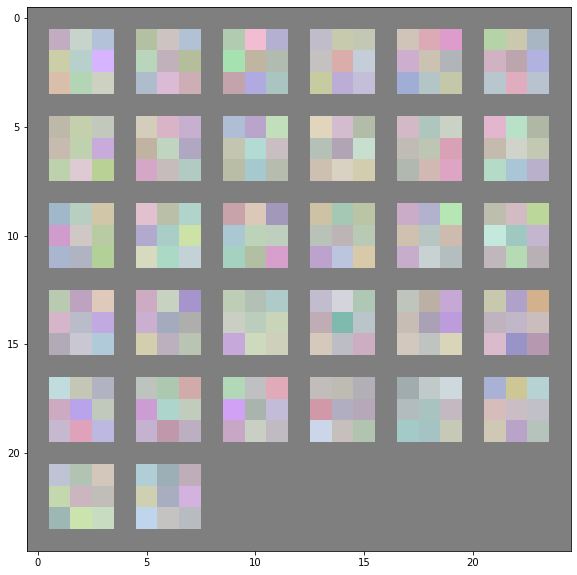

In [26]:
import matplotlib.pyplot as plt
import numpy as np


# 첫 번째 layer의 filter를 확인해보자 (=가중치 확인) -> 나중에 학습을 완료한 후의 filter도 확인하기
for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
imshow(x_grid)

## 파라미터 설정하기

In [27]:
# 모델 저장 함수 정의
def save_model(model, saved_dir):
  os.makedirs(saved_dir, exist_ok=True)  # 폴더가 존재하지 않으면, 디렉토리를 생성함.
  check_point = {
  'net': model.state_dict()
  #'optim' : optimizer.state_dict()
  #'loss' : loss.state_dict()
  #'epoch' : epoch.state_dict()
  }
  #output_path = os.path.join(saved_dir) # 옵션들을 합쳐 경로 지정
  torch.save(check_point, saved_dir+'/best_model_weight.pt') # 인수로 '모델의 매개 변수, 경로'를 넣어주면 된다.


In [28]:
# config 모델 파라미터 인자를 만들기위한 클래스
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [29]:
lr = 0.0008
epochs = 30
optimizer = 'Adam'

In [30]:
# # 파라미터 클래스 => tranfer.compose 함수를 사용해서 데이터 전처리 진행하는 경우
# config = Config(
#     trainloader = trainloader,
#     testloader = testloader,
#     model = resnet50,
#     device = device,
#     optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
#     criterion= nn.CrossEntropyLoss().to(device),
#     globaliter = 0
# )

In [31]:
# albumentations 사용해서 데이터 전처리 하는 경우
# 파라미터 클래스
config = Config(
    trainloader = albumentations_train_loader,
    testloader = albumentations_test_loader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [32]:
class train_test():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(self.trainloader))

      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              lr_sche.step()
              # scheduler.step()
              # optimizer.step()
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                  
                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                    #     epoch, i*len(inputs), len(self.trainloader.dataset),
                    #     100. * i*len(inputs) / len(self.trainloader.dataset), 
                    #     running_loss / log_interval,
                    #     loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)

              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)      # tensor 값으로 출력됨

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()     # correct: 잘 분류된 이미지 개수
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)
                    print("Real: ", labels)       #0(tiger), 1(flower), 2(letter) 값으로 출력됨
                    print("Predicted: ", predicted)

                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  # print("Test 결과:\n")
                  # print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                  #              for j in range(75)))   # batch size = 16
                  # print('Predicted labels: ', ' '.join('%5s' % classes[predicted[j]] 
                  #                             for j in range(75)))

                  
                  # * 모델 저장 시 아래 주석 풀고 진행하기!!

                  # with test_summary_writer.as_default():
                  #    summary.scalar('loss', test_loss , step = self.globaliter)
                  #    summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
                  #    if acc [k] > 60 and acc[k] > acc[k-1]:
                  #       torch.save({
                  #                   'epoch': epoch,
                  #                   'model_state_dict': self.model.state_dict(),
                  #                   'optimizer_state_dict': self.optimizer.state_dict(),
                  #                   'loss': test_loss
                  #                   }, PATH)
                         
      print('Finished Training')


Finished Training


In [33]:
print(classes)

# 0: tiger, 1: flower, 2: letter

('tiger', 'flower', 'letter')


In [34]:
ready_to_train=train_test(config)

31


In [35]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 200
log_interval = 175

model = ready_to_train.train(epochs, log_interval)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Train Epoch: 87 [256/486 (53%)]	learningLoss: 0.007546	whole_loss: 0.008646 
Train Epoch: 87 [272/486 (56%)]	learningLoss: 0.007653	whole_loss: 0.018726 
Train Epoch: 87 [288/486 (59%)]	learningLoss: 0.007714	whole_loss: 0.010775 
Train Epoch: 87 [304/486 (63%)]	learningLoss: 0.007739	whole_loss: 0.004406 
Train Epoch: 87 [320/486 (66%)]	learningLoss: 0.007926	whole_loss: 0.032632 
Train Epoch: 87 [336/486 (69%)]	learningLoss: 0.008783	whole_loss: 0.150001 
Train Epoch: 87 [352/486 (72%)]	learningLoss: 0.009612	whole_loss: 0.145152 
Train Epoch: 87 [368/486 (76%)]	learningLoss: 0.009802	whole_loss: 0.033242 
Train Epoch: 87 [384/486 (79%)]	learningLoss: 0.010747	whole_loss: 0.165330 
Train Epoch: 87 [400/486 (82%)]	learningLoss: 0.010846	whole_loss: 0.017346 
Train Epoch: 87 [416/486 (86%)]	learningLoss: 0.011574	whole_loss: 0.127416 
Train Epoch: 87 [432/486 (89%)]	learningLoss: 0.013085	whole_loss: 0.264398 
Train Epoch: 87 [448/486 (92%)]	learning

In [44]:
def saveModel():
    path = "./myFirstModel_0411.pth"
    torch.save(model, path)

In [46]:
# save_model(model, "/content/drive/MyDrive/민화 AI인턴/민화 AI인턴 (2)/220410")
saveModel()

In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to show the images
# def imageshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # Function to test the model with a batch of images and show the labels predictions
# def testBatch():
#     # get batch of images from the test DataLoader  
#     images, labels = next(iter(testloader))

#     # show all images as one image grid
#     imageshow(torchvision.utils.make_grid(images))
   
#     # Show the real labels on the screen 
#     print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
#                                for j in range(batch_size)))
  
#     # Let's see what if the model identifiers the  labels of those example
#     outputs = model(images)
    
#     # We got the probability for every 10 labels. The highest (max) probability should be correct label
#     _, predicted = torch.max(outputs, 1)
    
#     # Let's show the predicted labels on the screen to compare with the real ones
#     print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
#                               for j in range(batch_size)))

테스트 결과 확인하기

In [39]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to show the images
# def imageshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# def testBatch():
#   images, labels = next(iter(testloader))
#   imageshow(torchvision.utils.make_grid(images))
#   print('Real labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


# 텐서보드에 학습데이터 올리기

In [40]:
# albumentations_train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
#                                           shuffle=True, num_workers=0)

# albumentations_test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
#                                          shuffle=False, num_workers=0)

In [41]:
# # 타임스탬프
# from torch.utils.tensorboard import SummaryWriter
# from tensorflow import summary # 텐서보드에 기록하기 위한 함수
# import datetime

# time_stamp = str(datetime.datetime.now().timestamp())
# log_dir = 'runs/resnet' + time_stamp # runs 경로
# writer = SummaryWriter(log_dir)

# # 텐보 로드
# %load_ext tensorboard

In [42]:
# # 데이터 이름을 파라미터로 부여
# dataset = 'train_loader'
# model_parameter = str(dataset+'Adam_batch_size:{:.0f}, lr:{:.5f}'.format(albumentations_train_loader.batch_size, lr))

# # 텐서보드에 올릴 데이터 디렉토리 경로
# # train_log_dir = 'logs/tensorboard/train_'+model_parameter   # colab 런타임을 종료하면 없어지기 때문에 아래 경로로 로컬에 저장해놓음
# # test_log_dir = 'logs/tensorboard/test_'+model_parameter

# train_log_dir = '/content/drive/MyDrive/민화 AI인턴/민화 AI인턴 (2)/220403/ImageData/train'+model_parameter
# test_log_dir = '/content/drive/MyDrive/민화 AI인턴/민화 AI인턴 (2)/220403/ImageData/test'+model_parameter

# # 위 경로로 데이터를 텐보에 올릴 파일을 만듦
# train_summary_writer = summary.create_file_writer(train_log_dir)
# test_summary_writer =  summary.create_file_writer(test_log_dir)

In [43]:
# !pip install tensorboardX
# %tensorboard --logdir logs/tensorboard